## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from wordcloud import WordCloud, STOPWORDS

import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
!pip install scikit-plot
from scikitplot.metrics import plot_roc_curve

2023-07-09 18:44:03.330990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
# Check the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
# print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
# Assign new column names

df.rename(columns={'_source.product':'tag', '_source.complaint_what_happened':'complaints_what_happened'}, inplace=True)

In [8]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
df_filtered = df[['tag', 'complaints_what_happened']]

In [10]:
df_filtered.head()

,tag,complaints_what_happened
0,Debt collection,
1,Debt collection,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage,
4,Credit card or prepaid card,


In [11]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tag                       78313 non-null  object
 1   complaints_what_happened  78313 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [12]:
#Assign nan in place of blanks in the complaints column
df_filtered[df_filtered.loc[:, 'complaints_what_happened'] == ''] = np.nan

/var/folders/6y/qbtk58qn6xzg2hg96358lmd80000gn/T/ipykernel_31984/2293948616.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6y/qbtk58qn6xzg2hg96358lmd80000gn/T/ipykernel_31984/2293948616.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
# Verifying if blank values still exists in the dataframe
df_filtered[df_filtered.loc[:, 'complaints_what_happened'] == ''].shape

(0, 2)

In [14]:
df_filtered.head()

,tag,complaints_what_happened
0,NaN,NaN
1,Debt collection,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,NaN,NaN
4,NaN,NaN


In [15]:
#Remove all rows where complaints column is nan
df_filtered = df_filtered[~df_filtered['complaints_what_happened'].isnull()]

In [16]:
df_filtered.shape

(21072, 2)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
# Convert complaint_what_happened column to string for performing text operations
df_filtered['complaints_what_happened'] = df_filtered['complaints_what_happened'].astype(str)

In [18]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) # Remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'\d+\s', '', text) # Remove other numerical values
    return text

In [19]:
df_clean = pd.DataFrame(df_filtered['complaints_what_happened'].apply(clean_data))


In [20]:
df_clean

,complaints_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xx xx and was...
10,chase card was reported on xx xx however frau...
11,on xx xx while trying to book a xxxx xxxx tic...
14,my grand son give me check for i deposit it in...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xx xx xxxx i called chas my xxxx ...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs i ve had c...


In [21]:
# Write your function to Lemmatize the texts
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [22]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['complaints_lemmatized'] = df_clean['complaints_what_happened'].apply(lemmmatize_text)

In [23]:
df_clean

,complaints_what_happened,complaints_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...
10,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...
11,on xx xx while trying to book a xxxx xxxx tic...,on xx xx while try to book a xxxx xxxx ticke...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx I call chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs i ve had c...,I have have flawless credit for yrs I ve hav...


In [24]:
# Write your function to extract the POS tags 
def pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_pos_tag = " ".join(nn_words)
    return nn_pos_tag


In [25]:
# Extract Complaint after removing POS tags
df_clean['complaints_POS_removed'] = df_clean['complaints_lemmatized'].apply(pos_tags)

In [26]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints_what_happened,complaints_lemmatized,complaints_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,xxxx card agent anniversary date agent informa...
10,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...,chase card report application identity consent...
11,on xx xx while trying to book a xxxx xxxx tic...,on xx xx while try to book a xxxx xxxx ticke...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx I call chas my xxxx xx...,xxxx xxxx credit card provider claim purchase ...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs i ve had c...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...


In [27]:
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<Figure size 1000x600 with 0 Axes>

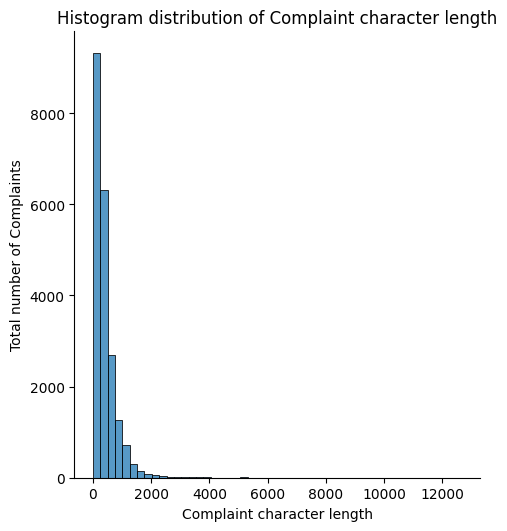

In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
char_len = [len(each_sent) for each_sent in df_clean['complaints_POS_removed']]
sns.displot(char_len, kind='hist', bins=50)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Histogram distribution of Complaint character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

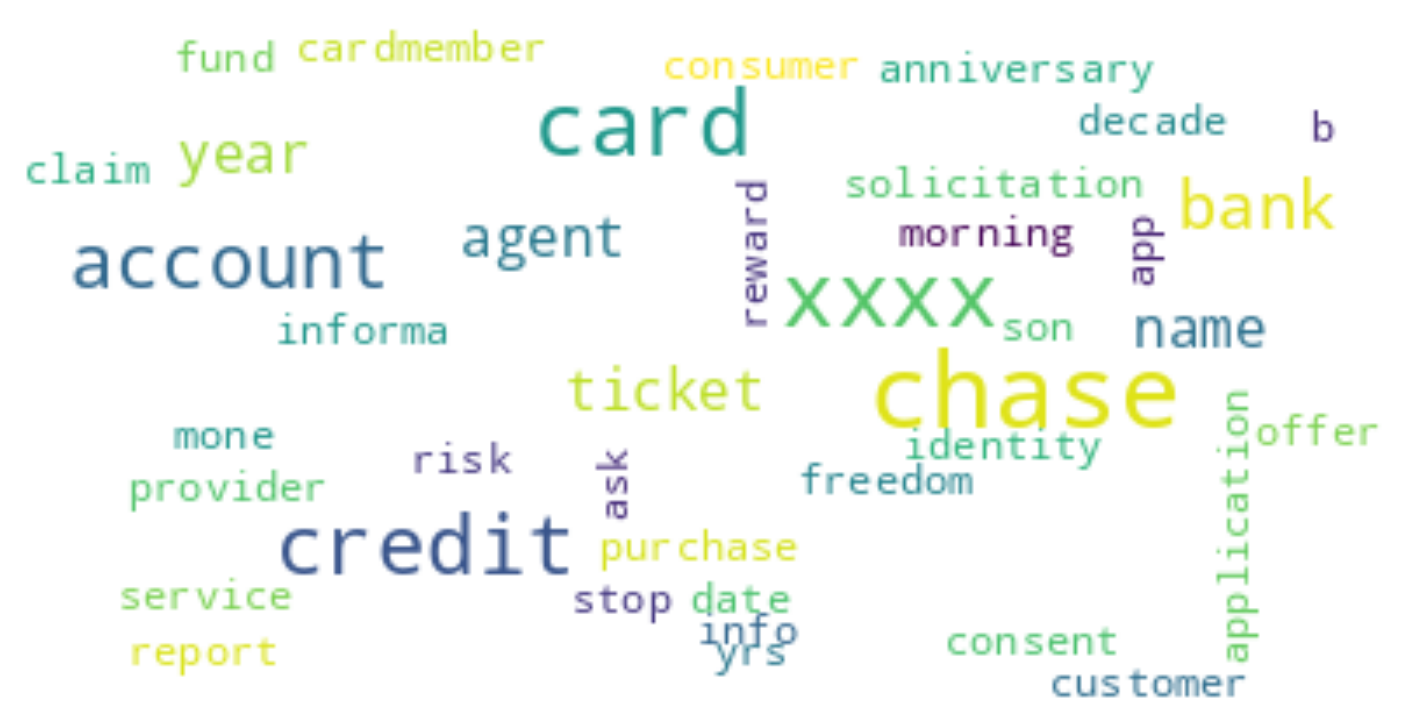

In [29]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=30, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaints_POS_removed']))
plt.figure(figsize=[18,18])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
#Removing -PRON- from the text corpus
df_clean['Complaints_clean'] = df_clean['complaints_POS_removed'].str.replace('-PRON-', '')

In summary, top words as observed from the word cloud are:
- credit
- account
- information
- ticket
- chase
- card
- bank

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bag_of_words = vec.transform(text)
  sum_words = bag_of_words.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [32]:
# Print the top 10 words in the unigram frequency
top_30words = get_top_ngrams(df_clean['Complaints_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,xxxx,59182
1,chase,53445
2,account,46835
3,credit,33630
4,card,30318
5,bank,21609
6,payment,21355
7,time,16293
8,charge,14239
9,day,13312


In [33]:
# Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 


In [34]:
#Print the top 10 words in the bigram frequency

In [35]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 


In [36]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [37]:
df_clean['Complaints_clean'] = df_clean['Complaints_clean'].str.replace('xxxx','')

In [38]:
# All masked texts has been removed
df_clean

,complaints_what_happened,complaints_lemmatized,complaints_POS_removed,Complaints_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...,chase card report application identity consent...,chase card report application identity consent...
11,on xx xx while trying to book a xxxx xxxx tic...,on xx xx while try to book a xxxx xxxx ticke...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx I call chas my xxxx xx...,xxxx xxxx credit card provider claim purchase ...,credit card provider claim purchase protecti...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...
78311,i have had flawless credit for yrs i ve had c...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
# Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaints_clean'])

In [41]:
dtm

<21072x6400 sparse matrix of type '<class 'numpy.float64'>'
	with 612135 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5

# Keep the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [44]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6400

In [45]:
# Topic-term matrix
H = nmf_model.components_      

In [46]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

print(topic_words)

          Word 1   Word 2       Word 3   Word 4       Word 5     Word 6   
Topic 1  account    check         bank    money         fund      chase  \
Topic 2     card   credit        chase  balance      account      limit   
Topic 3  payment     loan     mortgage    chase         home      month   
Topic 4   report  inquiry       credit  company  information  reporting   
Topic 5   charge  dispute  transaction    chase          fee   merchant   

               Word 7    Word 8    Word 9   Word 10   Word 11   Word 12   
Topic 1       deposit    branch       day  checking    number  business  \
Topic 2         score      year     point     month  purchase     offer   
Topic 3  modification      time      year      rate  property   balance   
Topic 4          debt  identity   account     theft     score    letter   
Topic 5         claim     fraud  purchase   service     email    refund   

           Word 13      Word 14   Word 15  
Topic 1   transfer  transaction  customer  
Topic 2   

Summary and Analysis:

Based on the topics listed above, we could give a label based on their products/services for each topic-

- Topic 1 = Bank Account services
- Topic 2 = Credit card or prepaid card
- Topic 3 = Mortgage/Loan
- Topic 4 = Theft/Dispute Reporting
- Topic 5 = Others

In [47]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [48]:
# Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [49]:
df_clean.head()

,complaints_what_happened,complaints_lemmatized,complaints_POS_removed,Complaints_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...,chase card report application identity consent...,chase card report application identity consent...,3
11,on xx xx while trying to book a xxxx xxxx tic...,on xx xx while try to book a xxxx xxxx ticke...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,3
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [50]:
# Print the first 5 Complaint for each of the Topics
df_clean_first5 = df_clean.groupby('Topic').head(5)
df_clean_first5.sort_values('Topic')

,complaints_what_happened,complaints_lemmatized,complaints_POS_removed,Complaints_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restrict my a...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,1
59,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,chase reward point month reward account bonus ...,chase reward point month reward account bonus ...,1
52,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
50,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card",
                2:"Mortgages/loans", 3:"Theft/Dispute reporting",
                4:"Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean

,complaints_what_happened,complaints_lemmatized,complaints_POS_removed,Complaints_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Credit card / Prepaid card
10,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...,chase card report application identity consent...,chase card report application identity consent...,Theft/Dispute reporting
11,on xx xx while trying to book a xxxx xxxx tic...,on xx xx while try to book a xxxx xxxx ticke...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,Theft/Dispute reporting
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card / Prepaid card
78309,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx I call chas my xxxx xx...,xxxx xxxx credit card provider claim purchase ...,credit card provider claim purchase protecti...,Others
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,Others
78311,i have had flawless credit for yrs i ve had c...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,Credit card / Prepaid card


In [53]:
df_clean.shape


(21072, 5)

In [54]:
df_clean.head()

,complaints_what_happened,complaints_lemmatized,complaints_POS_removed,Complaints_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Credit card / Prepaid card
10,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...,chase card report application identity consent...,chase card report application identity consent...,Theft/Dispute reporting
11,on xx xx while trying to book a xxxx xxxx tic...,on xx xx while try to book a xxxx xxxx ticke...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,Theft/Dispute reporting
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [55]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, 
               "Mortgages/loans":3, "Theft/Dispute reporting":4, 
                "Others":5}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [56]:
df_clean

,complaints_what_happened,complaints_lemmatized,complaints_POS_removed,Complaints_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx xx and was...,I upgrade my xxxx xxxx card in xx xx and be ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...,chase card report application identity consent...,chase card report application identity consent...,4
11,on xx xx while trying to book a xxxx xxxx tic...,on xx xx while try to book a xxxx xxxx ticke...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,4
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx I call chas my xxxx xx...,xxxx xxxx credit card provider claim purchase ...,credit card provider claim purchase protecti...,5
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,5
78311,i have had flawless credit for yrs i ve had c...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,1


In [57]:
#Keep the columns"complaints_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaints_what_happened', 'Topic']]

In [58]:
training_data

,complaints_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx xx and was...,1
10,chase card was reported on xx xx however frau...,4
11,on xx xx while trying to book a xxxx xxxx tic...,4
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xx xx xxxx i called chas my xxxx ...,5
78310,i am not familiar with xxxx pay and did not un...,5
78311,i have had flawless credit for yrs i ve had c...,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [59]:
# Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaints_what_happened'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pkl", "wb"))

In [60]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistic Regression

In [61]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [62]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

In [63]:
logistic_regression = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [64]:
# Getting the score of the base model
logistic_regression.score(X_test, y_test)


0.9104713698196774

Note: Accuracy with base logistic regression is roughly 91%

##### HyperParameter Tuning

In [66]:
# Setup grid hyperparameter search for LogisticRegression
logistic_regression_params = GridSearchCV(LogisticRegression(random_state=42, max_iter=500),
                                param_grid=logistic_regression_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logistic_regression_params.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid={'C': [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01]},
             verbose=True)

In [67]:
logistic_regression_params.best_params_

{'C': 3}

In [68]:
# Evaluating the tuned model
logistic_regression_params.score(X_test, y_test)

0.9115786143625435

The tuned model has an accuracy of 91.15% which is slight improvement over the base logitic regression model having accuracy of 91%

In [70]:
# Save Logistic Regression Model
pickle.dump(logistic_regression_params, open("logreg_model.pk1", "wb"))

##### Model Evaluation

In [71]:
# Load pickled model
logistic_regression_model = pickle.load(open("logreg_model.pk1", "rb"))

In [72]:
# Make predictions on test data
y_pred = logistic_regression_model.predict(X_test)

In [73]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1430   20   27   14   67]
 [  25 1112   12   20   54]
 [  18   14 1438   18   28]
 [  14   26   22  596   24]
 [  69   34   48    5 1187]]


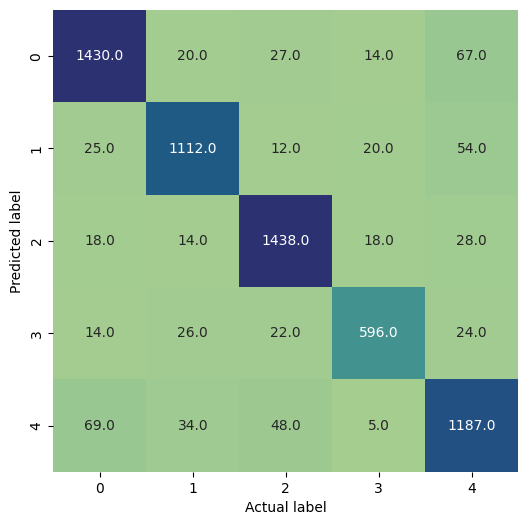

In [74]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="crest",
                 fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [75]:
Topic_names = ["Bank account services", "Credit card / Prepaid card", "Mortgages/loans", "Theft/Dispute reporting", "Others",]

In [76]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topic_names))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.92      0.92      1558
Credit card / Prepaid card       0.92      0.91      0.92      1223
           Mortgages/loans       0.93      0.95      0.94      1516
   Theft/Dispute reporting       0.91      0.87      0.89       682
                    Others       0.87      0.88      0.88      1343

                  accuracy                           0.91      6322
                 macro avg       0.91      0.91      0.91      6322
              weighted avg       0.91      0.91      0.91      6322



* Overall accuracy for logistic regression is roughly 91%.
* Precision and recall respectively for logistic regression is roughly 91% and 91% accuracy which is really good.

### Decision Tree Classifier

In [77]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [78]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

In [79]:
decision_tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)


In [80]:
# Getting the score of the base model
decision_tree.score(X_test, y_test)

0.7587788674470104

With base decision tree model, we are getting accuracy of roughly 75.87% 

##### HyperParameter Tuning

In [81]:
decision_tree_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [83]:
# Setup grid hyperparameter search for LogisticRegression
decision_tree_params = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=decision_tree_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
decision_tree_params.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             verbose=True)

In [84]:
# Check best parameters
decision_tree_params.best_params_

{'max_depth': 10, 'min_samples_leaf': 19, 'min_samples_split': 2}

In [85]:
# Evaluating the tuned model
decision_tree_params.score(X_test, y_test)

0.7421701993040177

* With the tuned Decision Tree model, we are getting an accuracy of 74.21% which is less than the base decision tree model's accuracy of 75.87%.

In [86]:
# Save Logistic Regression Model
pickle.dump(decision_tree_params, open("dt_model.pk1", "wb"))

#### Model Evaluation

In [87]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [88]:
# Make predictions on test data
y_pred = dt_model.predict(X_test)

In [89]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1126   56   73   28  275]
 [  62  933   20   80  128]
 [  72   63 1216   36  129]
 [  51   47   40  474   70]
 [ 168  111   78   43  943]]


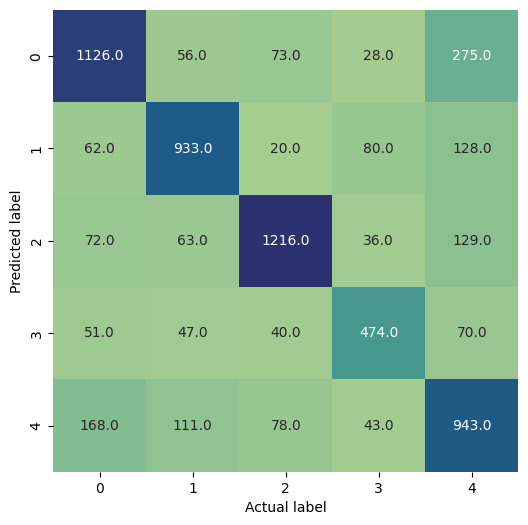

In [90]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="crest", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [91]:
Topic_names = ["Bank account services", "Credit card / Prepaid card", "Mortgages/loans", "Theft/Dispute reporting", "Others",]

In [93]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topic_names))

                            precision    recall  f1-score   support

     Bank account services       0.76      0.72      0.74      1558
Credit card / Prepaid card       0.77      0.76      0.77      1223
           Mortgages/loans       0.85      0.80      0.83      1516
   Theft/Dispute reporting       0.72      0.70      0.71       682
                    Others       0.61      0.70      0.65      1343

                  accuracy                           0.74      6322
                 macro avg       0.74      0.74      0.74      6322
              weighted avg       0.75      0.74      0.74      6322



* Overall accuracy of decision tree model is 74%.
* Precision and recall is 74% and 74% respectively.
* Looking at current scores, we could conclude that logistic regression model is preforming much better.

### Random Forest Classifier

In [94]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [95]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

In [96]:
random_forest_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)


In [97]:
# Getting the score of the base model
random_forest_model.score(X_test, y_test)

0.8128756722556153

The accuracy with base randm forest model is roughly 81.28%.

##### HyperParameter Tuning

In [98]:
random_forest_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [99]:
# Setup random hyperparameter search for LogisticRegression
random_forest_params = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=random_forest_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
random_forest_params.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [100]:
# Check best parameters
random_forest_params.best_params_


{'n_estimators': 910,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [101]:
# Evaluating the tuned model
random_forest_params.score(X_test, y_test)

0.7268269534957292

The model accuracy is roughly 72.68% and hence it needs further tuning.

In [102]:
random_forest_grid = {"n_estimators": [100, 200, 300],
           "max_depth": [5, 10, 15],
           "min_samples_split": [6, 8, 10],
           "min_samples_leaf": [6, 8, 10]}

In [103]:
# Setup grid hyperparameter search for LogisticRegression
random_forest_params = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=random_forest_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
random_forest_params.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=True)

In [104]:
# Check best parameters
random_forest_params.best_params_

{'max_depth': 15,
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'n_estimators': 200}

In [105]:
# Evaluating the tuned model
random_forest_params.score(X_test, y_test)

0.7633660234103132

After Grid Search, the Random Forest model has an accuracy of roughly 76.33%.

In [106]:
# Save Random Forest Model
pickle.dump(random_forest_params, open("rf_model.pk1", "wb"))

##### Model Evaluation

In [107]:
# Load pickled model
random_forest_model = pickle.load(open("rf_model.pk1", "rb"))

In [108]:
# Make predictions on test data
y_pred = random_forest_model.predict(X_test)

In [109]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1452   19   63    1   23]
 [ 214  721  108   13  167]
 [  61   16 1420    0   19]
 [  73  105  161  314   29]
 [ 264   31  128    1  919]]


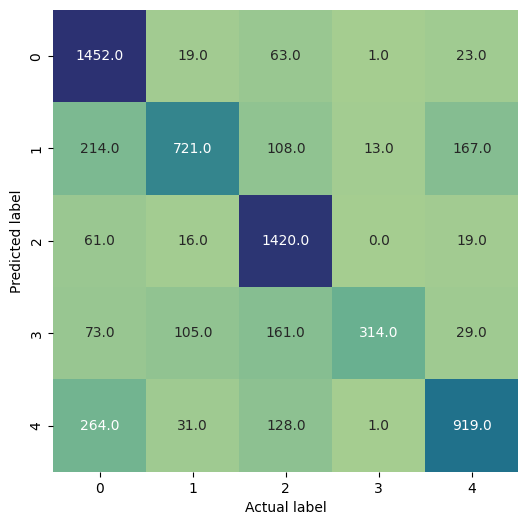

In [110]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="crest", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [111]:
Topic_names = ["Bank account services", "Credit card / Prepaid card", "Mortgages/loans", "Theft/Dispute reporting", "Others",]

In [112]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topic_names))

                            precision    recall  f1-score   support

     Bank account services       0.70      0.93      0.80      1558
Credit card / Prepaid card       0.81      0.59      0.68      1223
           Mortgages/loans       0.76      0.94      0.84      1516
   Theft/Dispute reporting       0.95      0.46      0.62       682
                    Others       0.79      0.68      0.74      1343

                  accuracy                           0.76      6322
                 macro avg       0.80      0.72      0.74      6322
              weighted avg       0.78      0.76      0.75      6322



* The overall accuracy of the Random Forest model is 76%
* Precision and Accuracy are 80% and 72% respectively and we can see that the model overfits for "Theft/Dispute reporting" category for Precision
* This is a poor model as compared to Logistic Regression where the accuracy was roughly 91%.

##### Overall Results:
We created three supervised models viz. Logistic Regression, Decision Tree Classifier and Random Forest Classifier to predict any new complaints to the relevant Topics.

##### Results
###### Logistic Regression
The overall accuracy of the Logistic Regression model is roughly 91%.
Precision and Recall are 91% and 91% respectively which makes this is a very good model.

###### Decision Tree
The overall accuracy of the Decision Tree model is 74%
Precision and Recall are 74% and 74% respectively.

###### Random Forest
The overall accuracy of the Random Forest model is 76%
Precision and Recall are 80% and 72% respectively.

##### Conclusion
Based on the above results, Logistic Regression is the best model with an accuracy of 91% with Precision and Recall as 91% and 91% respectively